<a href="https://colab.research.google.com/github/hardaatbaath/365-Days-Computer-Vision-Learning-Linkedin-Post/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4015    0  4015    0     0  13004      0 --:--:-- --:--:-- --:--:-- 13035
100  517k  100  517k    0     0   581k      0 --:--:-- --:--:-- --:--:--  959k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4035    0  4035    0     0  13924      0 --:--:-- --:--:-- --:--:-- 13961
100  392k  100  392k    0     0   467k      0 --:--:-- --:--:-- --:--:--  840k


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from datetime import datetime
from sklearn import preprocessing
import numpy as np
import talib

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
from keras.callbacks import History
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [3]:
def calculate_technical_indicators(df):
    # Calculate RSI
    df['RSI'] = talib.RSI(df['Close'],20)

    # Calculate BBANDS
    upper, middle, lower = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2)
    df['BBANDS_Upper'] = upper
    df['BBANDS_Middle'] = middle
    df['BBANDS_Lower'] = lower

    # Calculate MACD
    macd, signal, hist = talib.MACD(df['Close'], fastperiod=3, slowperiod=18, signalperiod=6)
    df['MACD'] = macd
    df['SIGNAL'] = signal
    df['HIST'] = hist

    # Calculate OBV
    df['OBV'] = talib.OBV(df['Close'], df['Volume'])

    # Calculate EMA
    df['EMA'] = talib.EMA(df['Close'], timeperiod=20)

    # Drop unwanted columns
    df.drop(columns=['Trades', 'Deliverable Volume', '%Deliverble'], inplace=True)

    # Remove the first 22 columns as it has NaN values
    df = df[23:]#.reset_index(drop=True, inplace=True)
    df = df.reset_index(drop=True, inplace=False)

    return df

In [4]:
def prepare_train_test_data(df, data_set_points, train_split):
    df = df.drop(columns=['Date', 'Symbol', 'Series'])
    df['Volume'] = df['Volume'].astype('float64')
    # df = df.loc[1:]

    # Split the data into train and test sets
    train_indices = int(df.shape[0] * train_split)
    train_data = df[:train_indices]
    test_data = df[train_indices:]
    test_data = test_data.reset_index(drop=True)

    # Prepare the training and test data
    X_train = tf.convert_to_tensor([train_data[i : i + data_set_points].values for i in range(len(train_data) - data_set_points)])
    y_train = tf.convert_to_tensor([[train_data['Close'][i + data_set_points]] for i in range(len(train_data) - data_set_points)])

    X_test = tf.convert_to_tensor([test_data[i : i + data_set_points].values for i in range(len(test_data) - data_set_points)])
    y_test = tf.convert_to_tensor([[test_data['Close'][i + data_set_points]] for i in range(len(test_data) - data_set_points)])

    return X_train, y_train, X_test, y_test, test_data

In [5]:
def lstm_model(X_train, y_train, data_set_points):
    #Setting of seed (to maintain constant result)
    tf.random.set_seed(20)
    np.random.seed(10)

    # Check if there are any NaN values in the training data
    if np.isnan(X_train).any() or np.isnan(y_train).any():
        print("NaN values found in training data. Please clean the data.")
        return None

    lstm_input = Input(shape=(data_set_points, 18), name='input_for_lstm')

    inputs = LSTM(21, name='first_layer', return_sequences = True)(lstm_input)

    inputs = Dropout(0.1, name='first_dropout_layer')(inputs)
    inputs = LSTM(32, name='lstm_1')(inputs)
    inputs = Dropout(0.05, name='lstm_dropout_1')(inputs) #Dropout layers to prevent overfitting
    inputs = Dense(32, name='first_dense_layer')(inputs)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(learning_rate = 0.0001)  # Reduced learning rate

    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=y_train, batch_size=25, epochs=5, shuffle=True, validation_split = 0.1)

    return model

In [12]:
def buy_sell_trades(actual, predicted):
    pred_df = pd.DataFrame()
    pred_df['Predictions'] = predicted


    y_pct_change = pred_df.pct_change()


    money = 10000
    initial_money = money
    number_of_stocks = (int)(10000 / actual[0])
    left = 10000 - (int)(10000 / actual[0]) * actual[0] + actual[len(actual) - 1] * number_of_stocks

    number_of_stocks = 0

    buying_percentage_threshold = 0.0015 #as long as we have a 0.15% increase/decrease we buy/sell the stock
    selling_percentage_threshold = 0.0015

    for i in range(len(actual) - 1):
        if y_pct_change['Predictions'][i + 1] > buying_percentage_threshold:
            for j in range(100, 0, -1):
                #Buying of stock
                if (money >= j * actual[i]):
                    money -= j * actual[i]
                    number_of_stocks += j
                    break
        elif  y_pct_change['Predictions'][i + 1] < -selling_percentage_threshold:
            for j in range(100, 0, -1):
                #Selling of stock
                if (number_of_stocks >= j):
                    money += j * actual[i]
                    number_of_stocks -= j
                    break

    money += number_of_stocks * actual[len(actual) - 1]

    print(f"If traded: {money}") #Money if we traded
    print(f"If buy and Sell: {left}")  #Money if we just bought as much at the start and sold near the end (Buy and hold)
    print(f"Profit Percentage: {(money - initial_money)/initial_money}") #Profit percentage

    return y_pct_change

In [10]:
def generate_predicted_result_based_on_previous_actual(actual, y_pred):
    temp_actual = actual[:-1]

    #Adding each actual price at time t with the predicted difference to get a predicted price at time t + 1
    new = np.add(temp_actual, y_pred[:-1])

    plt.gcf().set_size_inches(12, 8, forward=True)
    plt.title('Plot of real price and predicted price against number of days for test set')
    plt.xlabel('Number of days')
    plt.ylabel('AdjusPrev Close Price($)')

    plt.plot(actual[1:], label='Actual Price')
    plt.plot(new, label='Predicted Price')

    print(f"Mean Square Error: {mean_squared_error(actual[1:], new, squared = False)}")

    #plotting of model
    plt.legend(['Actual Price', 'Predicted Price'])


    plt.show()

In [8]:
# Load the data
# stock_df = pd.read_csv('/content/BPCL.csv')

# Calculate technical indicators
# stock_df = calculate_technical_indicators(stock_df)

# stock_df

# print(f"Stock information \n {stock_df.info()}")

# print(f"No of nan \n{stock_df.isna().sum()}")

# stock_df.to_csv('stock_df', index = True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/BPCL.csv'

Epoch 1/5
131/131 [==============================] - 6s 17ms/step - loss: 246680.2969 - val_loss: 4085025.2500
Epoch 2/5
131/131 [==============================] - 1s 8ms/step - loss: 243192.9219 - val_loss: 4061489.0000
Epoch 3/5
131/131 [==============================] - 1s 7ms/step - loss: 238683.5312 - val_loss: 4034266.5000
Epoch 4/5
131/131 [==============================] - 1s 7ms/step - loss: 233700.8281 - val_loss: 4005247.7500
Epoch 5/5
49/49 [==============================] - 1s 3ms/step
[ 4172.3         4204.43666916  4236.57333832 ... 53694.90717392
 53727.04384308 53759.18051224]


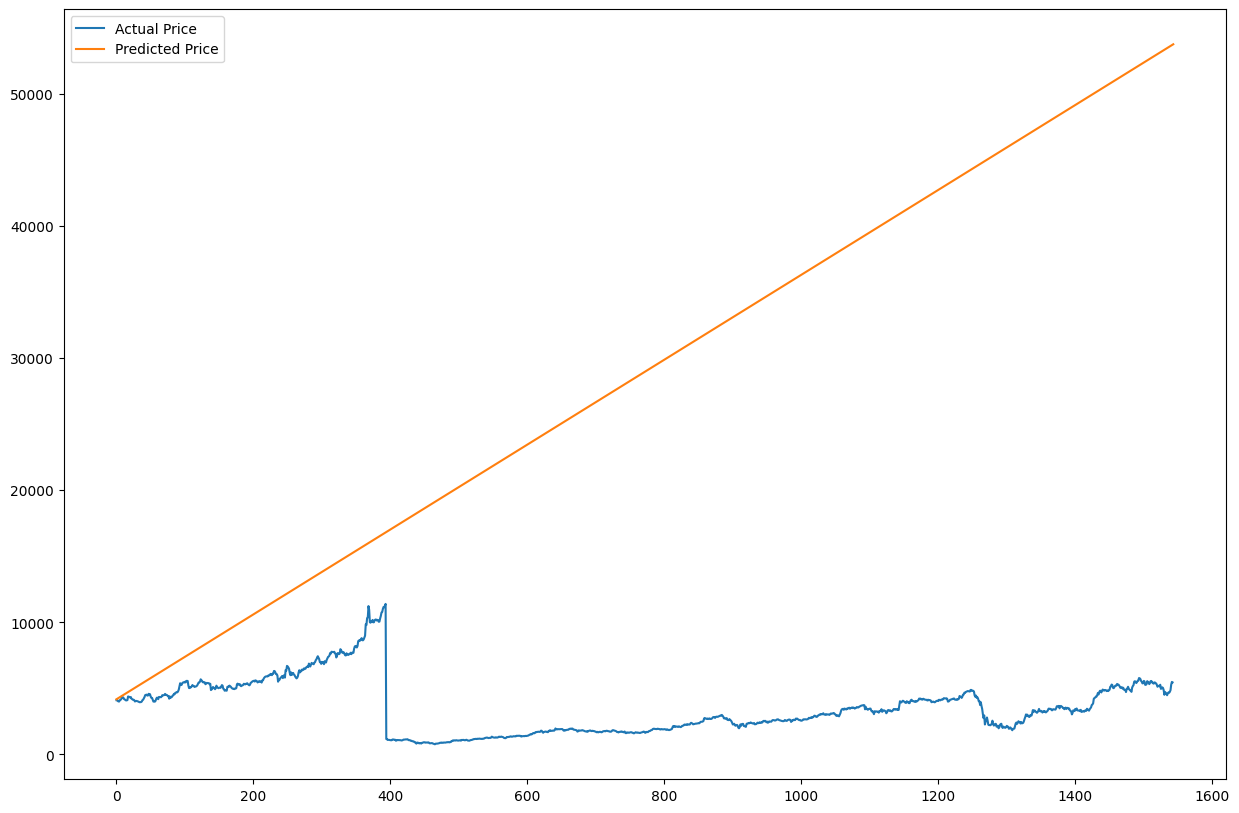

If traded: 16978.5
If buy and Sell: 12689.4
Profit Percnetage: 0.69785
Mean Square Error: 279.826649014655


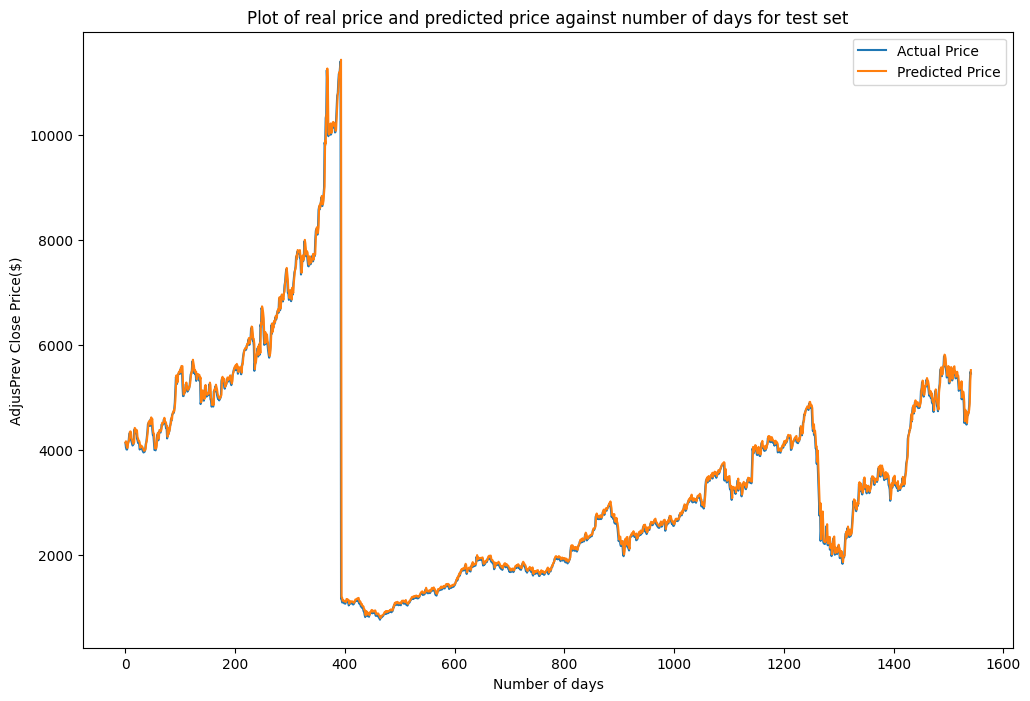

In [11]:
if __name__ == "__main__":
    start_date = datetime(2010, 9, 1)
    end_date = datetime(2020, 8, 31)

    train_split = 0.7

    data_set_points = 21

    # Load the data
    stock_df = pd.read_csv('BAJFINANCE.csv')

    # Calculate technical indicators
    stock_df = calculate_technical_indicators(stock_df)

    # print(f"Stock information \n {stock_df.info()}")

    # Prepare the training and test data
    X_train, y_train, X_test, y_test, test_data = prepare_train_test_data(stock_df, data_set_points, train_split)

    # print(f"Train information \n {X_train.shape}")
    # print(f"Pred information \n {y_train.shape}")

    # print(X_train[0,0])

    # print(f"Train information nan values \n {np.sum(np.isnan(X_train))}")
    # print(f"Pred information \n {np.sum(np.isnan(y_train))}")

    #Training of model
    model = lstm_model(X_train, y_train, data_set_points)

    #prediction of model
    y_pred = model.predict(X_test)

    y_pred = y_pred.flatten()

    #actual represents the test set's actual stock prices
    actual = np.array([test_data['Close'][i + data_set_points].copy() for i in range(len(test_data) - data_set_points)])

    #reference represents the stock price of the point before the prediction, so we can iteratively add the difference
    reference = test_data['Close'][data_set_points - 1]

    predicted = []

    predicted.append(reference)

    #adding of difference and appending to the list
    for i in y_pred:
        reference += i
        predicted.append(reference)

    predicted = np.array(predicted)

    # print(predicted)

    real = plt.plot(actual, label='Actual Price')
    pred = plt.plot(predicted, label='Predicted Price')

    plt.legend(['Actual Price', 'Predicted Price'])
    plt.gcf().set_size_inches(15, 10, forward=True)

    plt.show()

    #Use of an algorithm to buy and sell if it exceeds the threshold
    y_pct_change = buy_sell_trades(actual, predicted)

    generate_predicted_result_based_on_previous_actual(actual, y_pred)

49/49 [==============================] - 0s 3ms/step


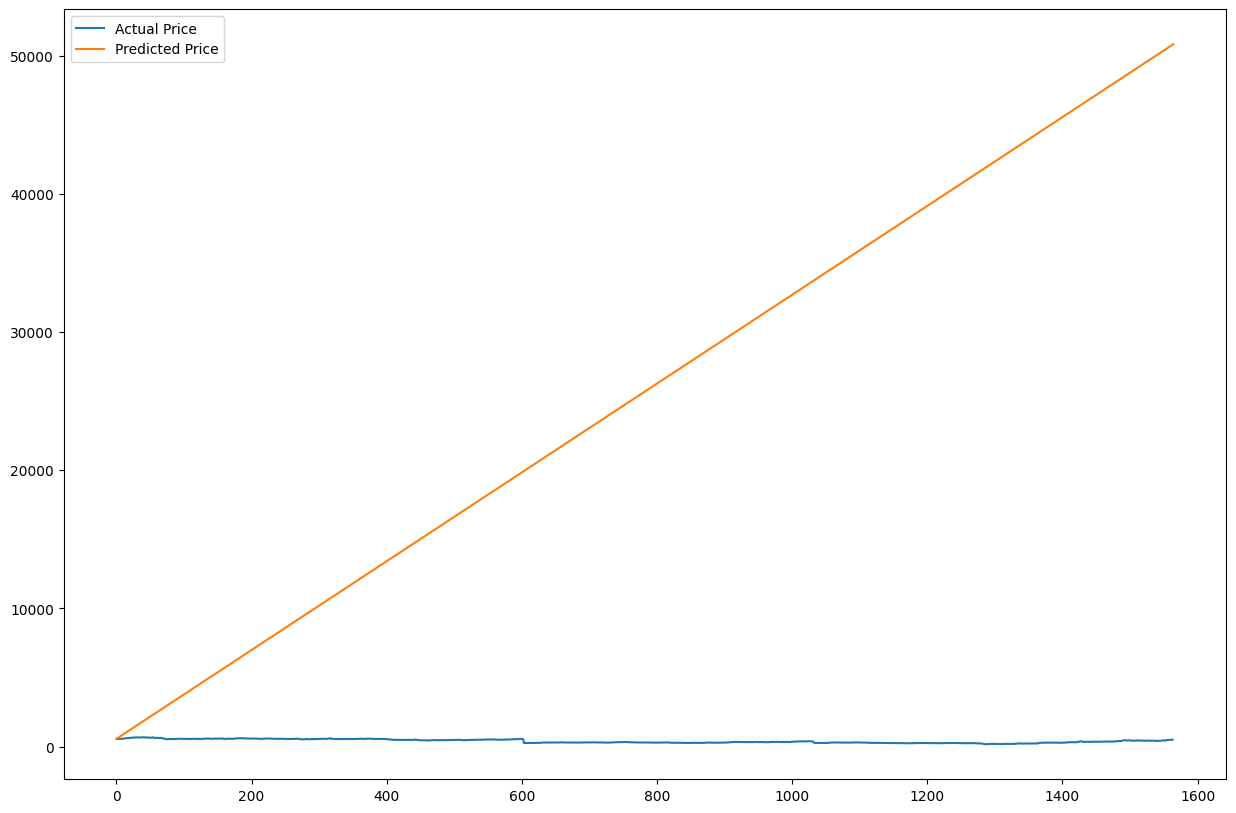

If traded: 8874.400000000001
If buy and Sell: 8885.650000000001
Profit Percentage: -0.11255999999999985
Mean Square Error: 33.511785902086466


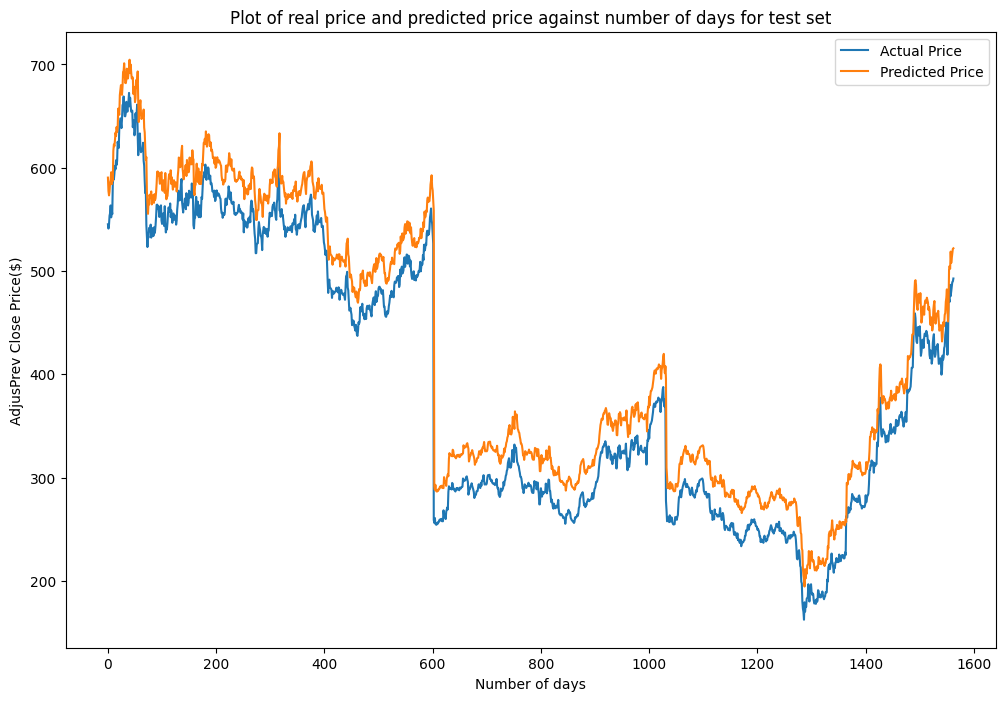

In [18]:
if __name__ == "__main__":
    start_date = datetime(2010, 9, 1)
    end_date = datetime(2020, 8, 31)

    train_split = 0.7

    data_set_points = 21

    # Load the data
    stock_df = pd.read_csv('/content/WIPRO.csv')

    # Calculate technical indicators
    stock_df = calculate_technical_indicators(stock_df)

    # print(f"Stock information \n {stock_df.info()}")

    # Prepare the training and test data
    X_train, y_train, X_test, y_test, test_data = prepare_train_test_data(stock_df, data_set_points, train_split)

    # print(f"Train information \n {X_train.shape}")
    # print(f"Pred information \n {y_train.shape}")

    # print(X_train[0,0])

    # print(f"Train information nan values \n {np.sum(np.isnan(X_train))}")
    # print(f"Pred information \n {np.sum(np.isnan(y_train))}")

    #Training of model
    # model = lstm_model(X_train, y_train, data_set_points)

    #prediction of model
    y_pred = model.predict(X_test)

    y_pred = y_pred.flatten()

    #actual represents the test set's actual stock prices
    actual = np.array([test_data['Close'][i + data_set_points].copy() for i in range(len(test_data) - data_set_points)])

    #reference represents the stock price of the point before the prediction, so we can iteratively add the difference
    reference = test_data['Close'][data_set_points - 1]

    predicted = []

    predicted.append(reference)

    #adding of difference and appending to the list
    for i in y_pred:
        reference += i
        predicted.append(reference)

    predicted = np.array(predicted)

    # print(predicted)

    real = plt.plot(actual, label='Actual Price')
    pred = plt.plot(predicted, label='Predicted Price')

    plt.legend(['Actual Price', 'Predicted Price'])
    plt.gcf().set_size_inches(15, 10, forward=True)

    plt.show()

    #Use of an algorithm to buy and sell if it exceeds the threshold
    y_pct_change = buy_sell_trades(actual, predicted)

    generate_predicted_result_based_on_previous_actual(actual, y_pred)